In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
plt.style.use('fivethirtyeight')

In [12]:
regular_season_df.columns

Index(['SEASON', 'DATE', 'HOME_TEAM', 'AWAY_TEAM', 'HOME_PTS', 'AWAY_PTS',
       'HOME_FG', 'AWAY_FG', 'HOME_FGA', 'AWAY_FGA', 'HOME_FG%', 'AWAY_FG%',
       'HOME_3PM', 'AWAY_3PM', 'HOME_3PA', 'AWAY_3PA', 'HOME_3P%', 'AWAY_3P%',
       'HOME_FT', 'AWAY_FT', 'HOME_FTA', 'AWAY_FTA', 'HOME_FT%', 'AWAY_FT%',
       'HOME_ORB', 'AWAY_ORB', 'HOME_DRB', 'AWAY_DRB', 'HOME_TRB', 'AWAY_TRB',
       'HOME_AST', 'AWAY_AST', 'HOME_STL', 'AWAY_STL', 'HOME_BLK', 'AWAY_BLK',
       'HOME_TOV', 'AWAY_TOV', 'HOME_PF', 'AWAY_PF', 'HOME_TS%', 'AWAY_TS%',
       'HOME_EFG%', 'AWAY_EFG%', 'HOME_3PAR', 'AWAY_3PAR', 'HOME_FTR',
       'AWAY_FTR', 'HOME_ORB%', 'AWAY_ORB%', 'HOME_DRB%', 'AWAY_DRB%',
       'HOME_TRB%', 'AWAY_TRB%', 'HOME_AST%', 'AWAY_AST%', 'HOME_STL%',
       'AWAY_STL%', 'HOME_BLK%', 'AWAY_BLK%', 'HOME_TOV%', 'AWAY_TOV%',
       'HOME_ORTG', 'AWAY_ORTG', 'HOME_DRTG', 'AWAY_DRTG', 'HOME_GAME_NUMBER',
       'HOME_REST', 'AWAY_GAME_NUMBER', 'AWAY_REST', 'GAME_TYPE'],
      dtype='object')

In [3]:
games_df = pd.read_csv('data/game/bbref_game_with_game_type.csv')
regular_season_df = games_df[(games_df['GAME_TYPE'] == 'regular_season') & (games_df['SEASON'] != '2019-2020')]


season_means_dict = {}
for team_file in os.listdir('data/team/box_regular_season_mean'):
    team_df = pd.read_csv(f'data/team/box_regular_season_mean/{team_file}')
    season_means_dict[team_file[:-4]] = team_df

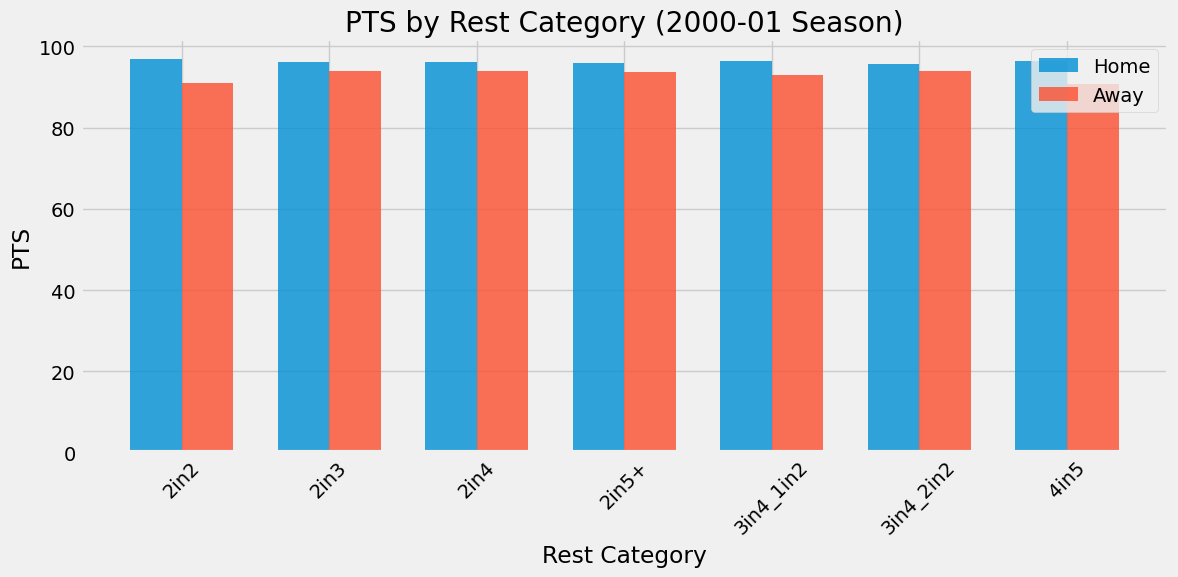

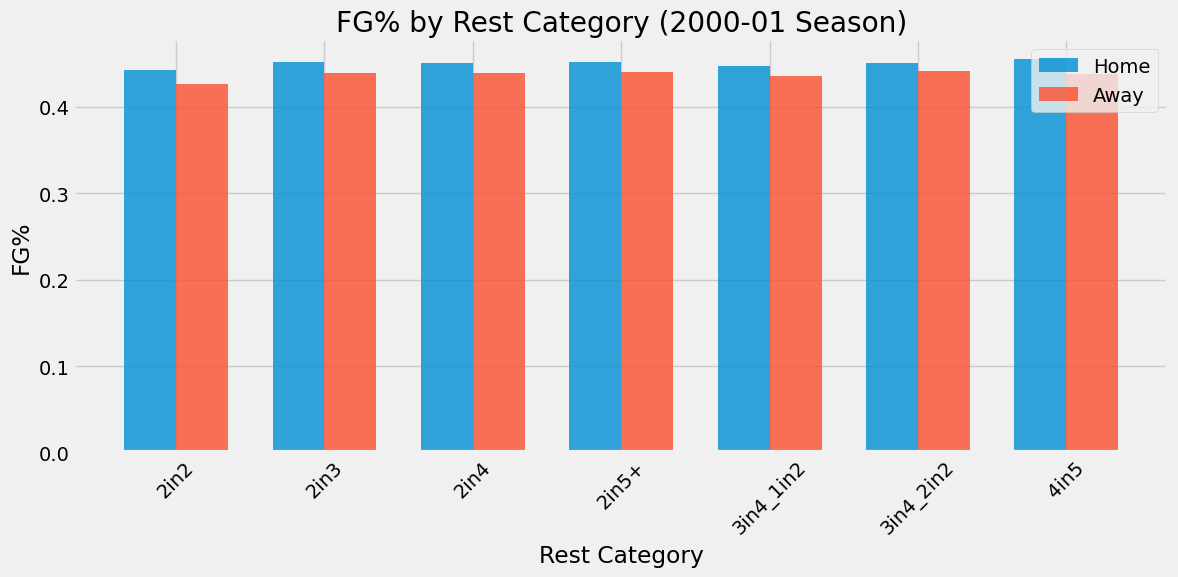

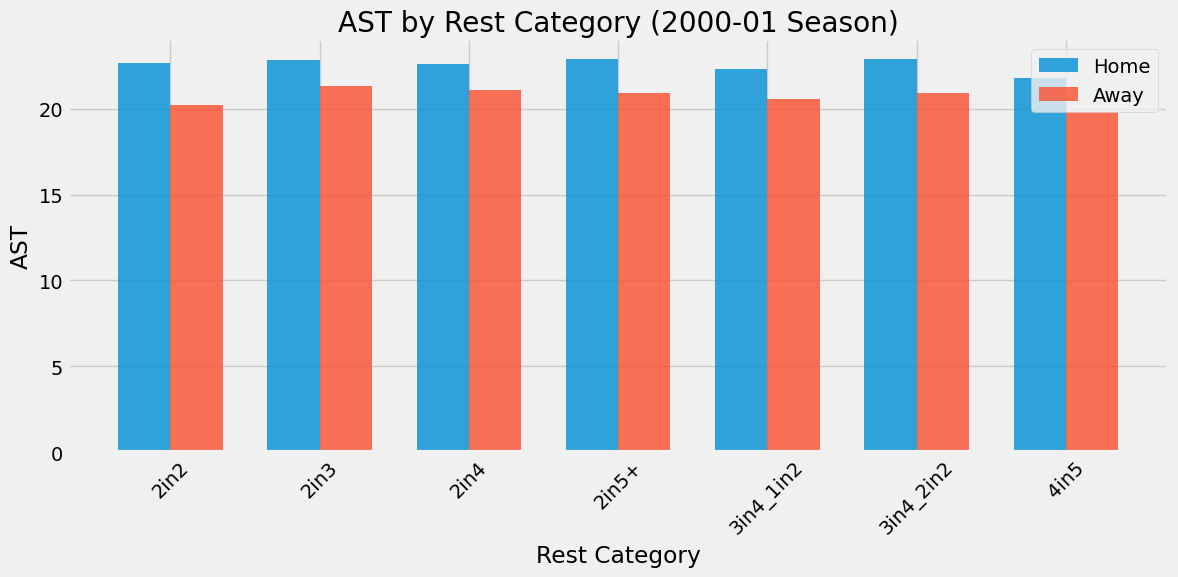

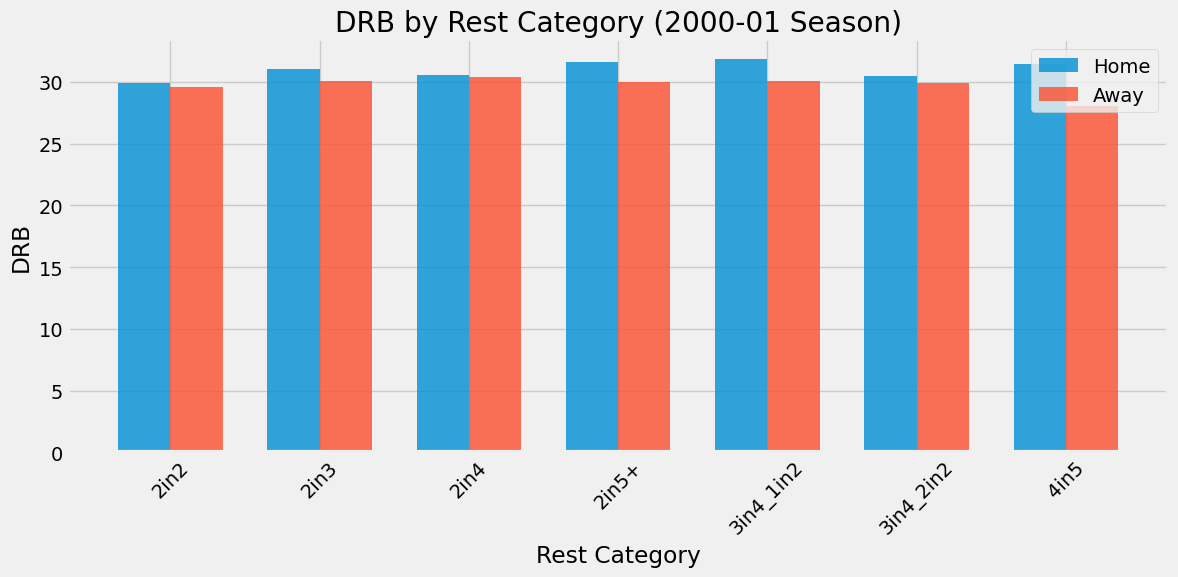

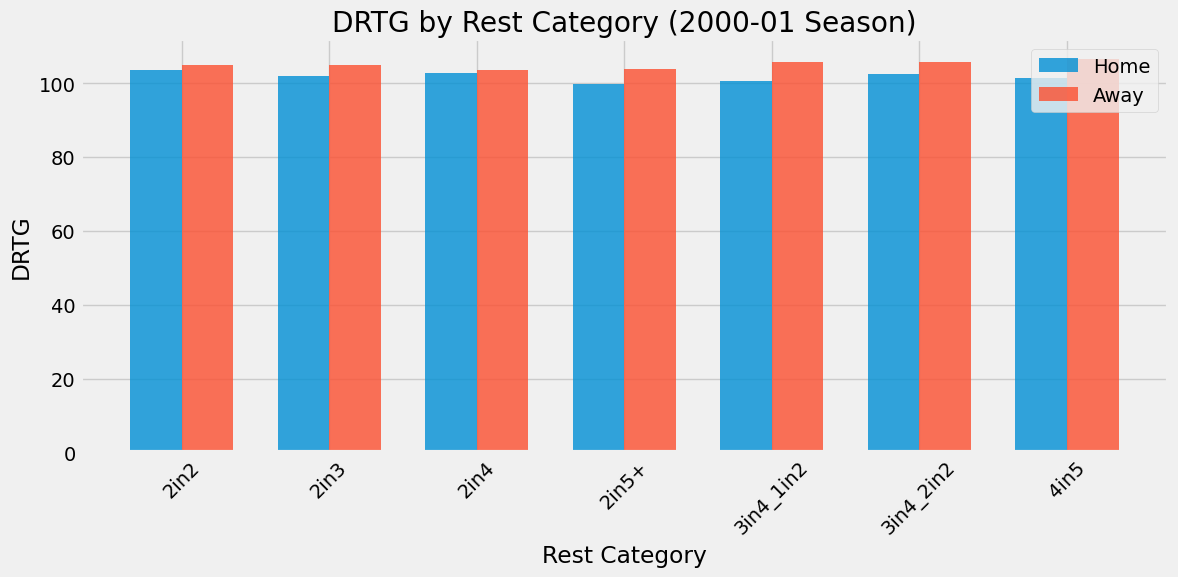

In [16]:
# Define the statistics we want to analyze
stats_to_analyze = ['PTS', 'FG%', 'AST', 'DRB', 'DRTG']

# Filter for 2000-01 season
season_df = regular_season_df[regular_season_df['SEASON'] == '2000-01']

# Create rest category bins
rest_categories = ['2in2', '2in3', '2in4', '2in5+', '3in4_1in2', '3in4_2in2', '4in5']

# For each statistic, create a plot comparing home vs away performance across rest categories
for stat in stats_to_analyze:
    plt.figure(figsize=(12,6))
    
    # Calculate means for home games
    home_means = [season_df[season_df['HOME_REST'] == rest][f'HOME_{stat}'].mean() 
                 for rest in rest_categories]
    
    # Calculate means for away games  
    away_means = [season_df[season_df['AWAY_REST'] == rest][f'AWAY_{stat}'].mean()
                 for rest in rest_categories]
    
    # Plot bars
    x = range(len(rest_categories))
    width = 0.35
    plt.bar([i - width/2 for i in x], home_means, width, label='Home', alpha=0.8)
    plt.bar([i + width/2 for i in x], away_means, width, label='Away', alpha=0.8)
    
    # Customize plot
    plt.xticks(x, rest_categories, rotation=45)
    plt.title(f'{stat} by Rest Category (2000-01 Season)')
    plt.xlabel('Rest Category')
    plt.ylabel(stat)
    plt.legend()
    plt.tight_layout()
